In [1]:
import requests
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from pandas.plotting import parallel_coordinates
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from IPython.display import clear_output




api_id = '1NNE'
api_beg = 'https://api.l2datamapping.com/api/v2/'
api_key = '6db5d606-d522-482f-add9-0c8e316bd53e'
api_item = 'Designated_Market_Area__DMA_'
major_parties = ['Republican','Democratic']#,'Non-Partisan']

top_n = 5

pallet = ['red', 'green', 'blue', 'orange', 'purple']

progress_amt = 3.125

In [2]:
state = "FL"

In [3]:
def get_dmas(state):
    global dmas
    global dmas_clean

    dmas = requests.get(f'{api_beg}customer/application/column/values/{api_id}/VM_{state}/{api_item}?id={api_id}&apikey={api_key}').json()['values']
    dmas_clean = [area[4:] for area in dmas]
    
    
    return dmas_clean

# Define the function to update the DMA dropdown options
def update_dma_options(new_state):
    dma_dropdown.options = get_dmas(new_state)
    global state
    state = new_state

def update_sel_dma(change):
    global selected_dma
    selected_dma = f'{state_dropdown.value}##{change.new}'
    
def replace_nearest_space(string, target_index, max_distance):
    """
    Replaces the closest space character before the target index with a newline character.
    Vertically centers both lines if they are split.
    """
    nearest_space_index = -1
    search_range = range(max(0, target_index - max_distance), target_index)
    for i in reversed(search_range):
        if string[i] == " ":
            nearest_space_index = i
            break

    if nearest_space_index != -1:
        string = string[:nearest_space_index] + "<br>" + string[nearest_space_index+1:]

    split_string = string.split('<br>')
    if len(split_string) == 2:
        first_line_len = len(split_string[0])
        second_line_len = len(split_string[1])

        padding = max(first_line_len, second_line_len) // 2
        split_string[0] = ' ' * padding + split_string[0] + ' ' * padding
        split_string[1] = ' ' * padding + split_string[1] + ' ' * padding

        string = '<br>'.join(split_string)

    return string


In [13]:
def create_spider_subplots(): 
    # Define the number of rows and columns of the subplot grid
    n_rows = (len(spider_df) + 2) // 3
    n_cols = 3

    # Define the list of colors

    # Create the subplots
    labels = spider_df['Cable System']
    fig = make_subplots(rows=n_rows, cols=n_cols, specs=[[{'type': 'polar'}]*n_cols]*n_rows,
                        subplot_titles=[f"<b>{replace_nearest_space(label,20,20)}</b>" for label in labels])
    progress.value += progress_amt
    
    # Iterate through the rows of spider_df and add a radar chart to each subplot
    for i, row in enumerate(spider_df.values):
        # Calculate the row and column of the current subplot
        row_num = (i // n_cols) + 1
        col_num = (i % n_cols) + 1

        # Add the radar chart to the subplot, using the corresponding color from the colors list
        fig.add_trace(
            go.Scatterpolar(
                r=row[1:],
                theta=spider_df.columns.tolist()[1:],
                fill='toself',
                name=row[0],
                showlegend=False,
                line=dict(color=pallet[i], width=2),
                fillcolor=pallet[i]
            ),
            row=row_num,
            col=col_num
        )
    progress.value += progress_amt
    
    for i in ['']+ list(range(1,len(spider_df.values)+1)):
        exec(f'fig.update_layout(polar{i}_radialaxis_tickvals=[])')
        exec(f"fig.update_layout(polar{i}=dict(radialaxis=dict(visible = True, range = [0,100])))")
    
    progress.value += progress_amt
    
    # Update the layout of the entire figure
    fig.update_layout(

        title={
            'text': selected_dma[4:],
            'x': 0.5, # set the x-coordinate to center the title
            'y': .97, # set the y-coordinate to position the title above the subplots
            'font': {'size': 20}, # set the font size of the title
            'xanchor': 'center',
            'yanchor': 'top'
        },
        margin=dict(t=90)
    )

    progress.value += progress_amt

    fig.update_annotations(font_size=12,height=70)
    # Show the figure
    fig.show()

In [5]:
def create_spider_plot():
    cable_systems = spider_df['Cable System'].unique()
    
    progress.value += progress_amt
    
    fig = go.Figure()

    for i, cable_sys in enumerate(cable_systems):    
        fig.add_trace(go.Scatterpolar(
            r=spider_df[spider_df['Cable System'] == cable_sys].drop(columns=['Cable System']).values.tolist()[0],
            theta=spider_df[spider_df['Cable System'] == cable_sys].drop(columns=['Cable System']).keys(),
            fill='toself',
            name=cable_sys,
            opacity=.3,
            line=dict(color=pallet[i], width=1),
            fillcolor=pallet[i]
        ))
    
    progress.value += progress_amt
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100]
            )
        ),
        legend=dict(
            x=1,
            y=.5
        ),
        showlegend=True,

        title={
            'text': selected_dma[4:],
            'x': 0.5, # set the x-coordinate to center the title
            'y': .95, # set the y-coordinate to position the title above the subplots
            'font': {'size': 20}, # set the font size of the title
            'xanchor': 'center',
            'yanchor': 'top'
        },
        margin=dict(t=90)
    )
    
    progress.value += progress_amt

    # Update the layout of the entire figure

    fig.show()

In [6]:
def par_coord_plot():
    
    progress.value += progress_amt
    
    df = spider_df.rename(columns={"Cable System Pop %":"Cable System\nPopulation %"})
    dimensions = [dim for dim in df.keys()[1:]]

    progress.value += progress_amt

    fig, ax = plt.subplots(figsize=(25,17))
    parallel_coordinates(df, 'Cable System',dimensions, color=pallet, linewidth=7)
    ax.legend(loc='best',prop={'size':18})
    ax.tick_params(axis='x', labelsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
    ax.set_ybound([0,100])

    # ax.grid(False)
    
    progress.value += progress_amt

    plt.tight_layout()
    plt.show()

In [7]:
# from Python Graph Gallery

def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment

def add_labels(angles, values, labels, offset, ax, fontsize):

    # This is the space between the end of the bar and the label
    padding = .02

    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle

        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor", 
            size=fontsize,
            fontweight='bold',
            bbox=dict(facecolor='white', alpha=1, edgecolor='none', boxstyle='round')
        )

def melt_df(spider_df):
    # Load the original DataFrame
    df = spider_df.rename(columns={"Cable System Pop %":"Cable System\nPopulation %"}).copy()

    # Melt the DataFrame to reshape it
    melted_df = df.melt(id_vars='Cable System', var_name='Category', value_name='Percent')

    # Set the index to a multiindex
    melted_df = melted_df.set_index(['Category', 'Cable System'])

    # rename index
    melted_df.index.names = ['Category', 'Sub-Category']

    # change index columns to regular columns
    melted_df = melted_df.reset_index()
    
    return melted_df


def circle_bar_chart():
    
    progress.value += progress_amt
    
    df = melt_df(spider_df)

    VALUES = df["Percent"].values
    LABELS = df["Sub-Category"].values
    GROUP = df["Category"].values

    PAD = 2
    ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
    ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
    WIDTH = (2 * np.pi) / len(ANGLES)
    OFFSET = np.pi / 2

    progress.value += progress_amt
    
    offset = 0
    IDXS = []
    GROUPS_SIZE = [df.Category.value_counts()[group] for group in df.Category.unique()]
    for size in GROUPS_SIZE:
        IDXS += list(range(offset + PAD, offset + size + PAD))
        offset += size + PAD

    progress.value += progress_amt

    # Create a colormap that repeats the color pattern for each group
    num_colors = len(df["Sub-Category"].unique())
    colors = []
    for size in GROUPS_SIZE: 
        colors += ['grey']*PAD
        colors += pallet[:size]
    cmap = mcolors.ListedColormap(colors)

    progress.value += progress_amt
    
    fig, ax = plt.subplots(figsize=(50, 50), subplot_kw={"projection": "polar"})
    ax.set_theta_offset(OFFSET)
    ax.set_ylim(-60, max(VALUES))
    ax.set_xlim(0,2 * np.pi)
    ax.set_frame_on(False)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, color='grey',linestyle='dotted')
    ax.set_xticks([])

    progress.value += progress_amt
    
    ax.set_rgrids(np.arange(0,110,10), angle=10)
    ax.tick_params(axis='y', labelsize=30)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, symbol='%')) 

    Category_fontsize = 50
    Sub_category_fontsize = 40

    # add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax, Sub_category_fontsize)

    # This iterates over the sizes of the groups adding reference
    # lines and annotations.

    progress.value += progress_amt
    
    offset = 0 
    for group, size in zip(df['Category'].unique().tolist(), GROUPS_SIZE):
        IDXS_group   =   IDXS[offset:offset+size+PAD]   #np.concatenate([     , [0] * PAD])
        VALUES_group = VALUES[offset:offset+size+PAD] #np.concatenate([     , [0] * PAD])
        LABELS_group = LABELS[offset:offset+size+PAD] #np.concatenate([     , [0] * PAD])

        # Add bars
        ax.bar(
            ANGLES[IDXS_group], height=VALUES_group, width=WIDTH, color=cmap(IDXS_group), 
            edgecolor="white", linewidth=5
        )

        # Add labels to bars
    #     add_labels(ANGLES[IDXS_group], VALUES_group+2, LABELS_group, OFFSET, ax, Sub_category_fontsize)

        # Add line below bars
        x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD-1], num=50,endpoint=False)
        ax.plot(x1, [-3] * 50, color="black", lw=2)


        # Add text to indicate group
        label_x = (ANGLES[offset+size+PAD-1]+ANGLES[offset+PAD])/2
        label_y = -25
        label_angle = (ANGLES[offset+size+PAD-1]+ANGLES[offset+PAD])/2*(180/np.pi)-90

        if label_angle > 90 and label_angle < 270:
            label_angle += 180

        ax.text(label_x, label_y, group, color="black", fontsize=Category_fontsize, 
                fontweight="bold", ha="center", va="center", 
                rotation=label_angle)

        offset += size + PAD

    progress.value += progress_amt

    # create legend handles
    handles = []
    
    progress.value += progress_amt
    
    for subcat, color in zip(df["Sub-Category"].unique(), colors[PAD:]):
        patch = mpatches.Patch(color=color, label=subcat)
        handles.append(patch)

    progress.value += progress_amt    
    
    # create legend and add to plot
    ax.legend(handles=handles, bbox_to_anchor=(1.1, 1), fontsize=30)
    
    progress.value += progress_amt

In [8]:
def create_dfs():
    try:
        global final_df, pc_df, spider_df
        # selected_dmas_idxs = np.where(np.array(dmas_clean),selected_dmas)
        # selected_dma = dmas[np.argwhere(np.array(dmas_clean) == selected_dmas_clean)[0][0]]

        # print('\nSelected DMA indicies:',*selected_dmas_clean,sep='\n')
        dma_to_cable_sys_short = {}
        dma_to_cable_sys_counts = {}
        df1 = pd.DataFrame()

        dma_cable_systs = pd.DataFrame(requests.post(        
            f'{api_beg}records/search/{api_id}/VM_{state}?id={api_id}&apikey={api_key}',
            json = {
                "format": "counts",
                "filters": {"Designated_Market_Area__DMA_":[selected_dma]},
                "columns": [
                    "cable_system_short"
                ]
            }
        ).json()).nlargest(top_n, '__COUNT').reset_index(drop=True).to_dict(orient='records')

        progress.value += progress_amt
        
        dma_to_cable_sys_short[selected_dma] = [cable_sys['cable_system_short'] for cable_sys in dma_cable_systs]
        dma_to_cable_sys_counts[selected_dma] = {cable_sys['cable_system_short']:cable_sys['__COUNT'] for cable_sys in dma_cable_systs}

        progress.value += progress_amt

        for cable_sys in dma_to_cable_sys_short[selected_dma]:
            json = requests.post(
                f'{api_beg}records/search/{api_id}/VM_{state}?id={api_id}&apikey={api_key}',
                json={
                    "format": "counts",
                    "filters": {
                        "Designated_Market_Area__DMA_":[selected_dma],
                        "cable_system_short": [cable_sys]
                    },
                    "columns": [
                        "Voters_AgeRange",
                        "Parties_Description",
                        "Voters_Gender"
                        ]}).json()
            cable_sys_df = pd.DataFrame(json, index=np.arange(len(json)))

            cable_sys_df["Designated_Market_Area__DMA_"] = selected_dma
            cable_sys_df["cable_system_short"] = cable_sys

            df1 = pd.concat([df1,cable_sys_df])
        progress.value += progress_amt

        for dma, cable_sys in dma_to_cable_sys_counts.items():
            for key in cable_sys:
                if cable_sys[key] == '':
                    cable_sys[key] = 'Other'


        df1['Parties_Description'] = df1['Parties_Description'].apply(
            lambda x: x if x in major_parties else 'Other'
        )

        progress.value += progress_amt

        df1 = df1.rename(columns={'cable_system_short':'cable_system','__COUNT': "Count"})
        df1.Count = pd.to_numeric(df1.Count)

        progress.value += progress_amt

        df1['Voters_Gender'] = df1['Voters_Gender'].apply(
            lambda x: x if x in {"M","F"} else 'O'
        )

        df1['Voters_AgeRange'] = df1['Voters_AgeRange'].apply(
            lambda x: x if x != "" else pd.NA
        )

        df = df1.copy()

        progress.value += progress_amt

        # calculate the total count for each DMA and cable system
        total_counts = df.groupby(['Designated_Market_Area__DMA_', 'cable_system'])['Count'].sum().reset_index()
        dma_total_counts = df.groupby(['Designated_Market_Area__DMA_'])['Count'].sum().reset_index()

        # GENDER

        # group by DMA and cable system, and gender
        grouped_gender = df.groupby(['Designated_Market_Area__DMA_', 'cable_system', 'Voters_Gender'])['Count'].sum().reset_index()

        # merge the two dataframes to get the total count for each gender in each DMA and cable system
        merged_gender = pd.merge(grouped_gender, total_counts, on=['Designated_Market_Area__DMA_', 'cable_system'], suffixes=('_gender', '_total'))

        # calculate the percentage of each gender in each DMA and cable system
        merged_gender['Percent'] = merged_gender['Count_gender'] / merged_gender['Count_total'] * 100

        # create the pivot table
        pivot_gender = merged_gender.pivot_table(index=['Designated_Market_Area__DMA_', 'cable_system'], columns='Voters_Gender', values='Percent').reset_index()

        progress.value += progress_amt

        # AGE

        # group by DMA and cable system, and gender
        grouped_age = df.groupby(['Designated_Market_Area__DMA_', 'cable_system', 'Voters_AgeRange'])['Count'].sum().reset_index()

        # merge the two dataframes to get the total count for each gender in each DMA and cable system
        merged_age = pd.merge(grouped_age, total_counts, on=['Designated_Market_Area__DMA_', 'cable_system'], suffixes=('_age', '_total'))

        # calculate the percentage of each gender in each DMA and cable system
        merged_age['Percent'] = merged_age['Count_age'] / merged_age['Count_total'] * 100

        # create the pivot table
        pivot_age = merged_age.pivot_table(index=['Designated_Market_Area__DMA_', 'cable_system'], columns='Voters_AgeRange', values='Percent').reset_index()

        progress.value += progress_amt

        # PARTY

        # group by DMA and cable system, and gender
        grouped_party = df.groupby(['Designated_Market_Area__DMA_', 'cable_system', 'Parties_Description'])['Count'].sum().reset_index()

        # merge the two dataframes to get the total count for each gender in each DMA and cable system
        merged_party = pd.merge(grouped_party, total_counts, on=['Designated_Market_Area__DMA_', 'cable_system'], suffixes=('_party', '_total'))

        # calculate the percentage of each gender in each DMA and cable system
        merged_party['Percent'] = merged_party['Count_party'] / merged_party['Count_total'] * 100

        # create the pivot table
        pivot_party = merged_party.pivot_table(index=['Designated_Market_Area__DMA_', 'cable_system'], columns='Parties_Description', values='Percent').reset_index()

        progress.value += progress_amt

        # merge the age and gender pivot tables
        pivot = pd.merge(pivot_age,pivot_gender, on=['Designated_Market_Area__DMA_','cable_system'])
        pivot = pd.merge(pivot,pivot_party, on=['Designated_Market_Area__DMA_','cable_system'])

        total_counts.rename(columns={'Count':'Cable_System_pop'}, inplace=True)
        pivot = pd.merge(pivot,total_counts, on=['Designated_Market_Area__DMA_','cable_system'])
        dma_total_counts.rename(columns={'Count':'DMA_pop'}, inplace=True)
        pivot = pd.merge(pivot, dma_total_counts)
        pivot['Cable System Pop %'] = pivot['Cable_System_pop'] / pivot['DMA_pop'] * 100

        progress.value += progress_amt

        # rename the columns to include the suffix "_pc"
        # pivot = pivot.rename(columns={'M': 'M_pc', 'F': 'F_pc'})

        # add a overall row
        # overall_row = pd.DataFrame(pivot.iloc[:, 2:].mean()).T
        # overall_row["Designated_Market_Area__DMA_"] = "Overall"
        # overall_row["cable_system"] = "Overall"
        # overall_row['Cable_System_pop_%'] = overall_row['Cable_System_pop_%'] / pivot.cable_system.nunique()
        # overall_row['Cable_System_pop'] = overall_row['Cable_System_pop'] * pivot.cable_system.nunique()
        # overall_row['DMA_pop'] = overall_row['DMA_pop'] * pivot.Designated_Market_Area__DMA_.nunique()

        # add overall row and rest of pivot df
        # final_df = pivot.append(overall_row)
        final_df = pivot.copy() 

        # remove the 'O' gender and 'Other' party columns
        if 'O' in final_df.columns:
            final_df = final_df.drop(columns=['O'])

        # create larger age bins (18 to 34, 35 to 64, 65+)
        age_bin1 = "18 to 19	20 to 24	25 to 29".split("\t")
        age_bin2 = "30 to 34	35 to 39	40 to 44	45 to 49	50 to 54".split("\t")
        age_bin3 = "55 to 64	65 and over".split("\t")

        final_df.insert(2,'Under 30',final_df.loc[:,age_bin1].sum(axis=1))
        final_df.insert(3,'30 to 54',final_df.loc[:,age_bin2].sum(axis=1))
        final_df.insert(4,'55 and over',final_df.loc[:,age_bin3].sum(axis=1))
        final_df.drop(columns=np.concatenate([np.concatenate([age_bin1,age_bin2]),age_bin3]),inplace=True)

        final_df.rename(columns={'Designated_Market_Area__DMA_':'DMA','cable_system':'Cable System'}, inplace=True)

        # drop empty rows
        final_df.dropna(inplace=True)
        final_df.sort_values('Cable_System_pop', inplace=True, ascending=False)

        final_df.reset_index(inplace=True, drop=True)

        progress.value += progress_amt

        # create df for spider plots
        spider_df = final_df.drop(columns=["DMA", "Cable_System_pop","DMA_pop"]).copy()


        # create df for parallel coordinate plots

        # par_coord_df = spider_df.iloc[:,1:]

        # grpd_bar_chrt = spider_df.iloc[:,1:]


        # create df with values rounded and with % sign
        pc_df = final_df.iloc[:,1:].copy()
        pc_df.iloc[:,1:-3] = pc_df.iloc[:,1:-3].applymap(lambda x: f"{x:.2f} %")
        pc_df.iloc[:,-1:] = pc_df.iloc[:,-1:].applymap(lambda x: f"{x:.2f} %")
        pc_df.iloc[:,-3:-1] = pc_df.iloc[:,-3:-1].applymap(lambda x: f"{x:,.0f}")

        pc_df.set_index("Cable System",inplace=True)

        progress.value += progress_amt
    except: None

In [9]:
def on_button_clicked(b):
    try:
        progress.value = 0
        create_dfs()
        clear_output(wait=True)

        display(state_dma_hbox)
        display(pc_df)
        create_spider_plot()
        create_spider_subplots()
        par_coord_plot()
        circle_bar_chart()
    except: None

In [10]:

# Define the State dropdown
state_options = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
state_dropdown = widgets.Dropdown(options=state_options, value='AL', description='State:', visible=False)

# Define the DMA dropdown
dma_dropdown = widgets.Dropdown(description='DMA:')

# Create generate button
generate_button = widgets.Button(description='Generate Report')

# Create progress bar
progress = widgets.FloatProgress(
    value=0.0,
    min=0.0,
    max=100.0,
    description='Progress:',
    bar_style='info',
    style={'bar_color': 'blue'},
    visible=False
)

# create horizontal box with widgets
state_dma_hbox = widgets.HBox([state_dropdown, dma_dropdown, generate_button, progress])

widgets.interact(update_dma_options, new_state=state_dropdown)
dma_dropdown.observe(update_sel_dma, names='value')
generate_button.on_click(on_button_clicked)


interactive(children=(Dropdown(description='State:', options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', …

,Under 30,30 to 54,55 and over,F,M,Democratic,Other,Republican,Cable_System_pop,DMA_pop,Cable System Pop %
Cable System,,,,,,,,,,,
"Effectv/Ft. Myers, FL (7654)",16.53 %,34.01 %,49.41 %,53.40 %,46.52 %,28.47 %,32.33 %,39.20 %,"216,622","806,592",26.86 %
"Effectv/Cape Coral, FL (7651)",12.23 %,31.80 %,55.93 %,52.08 %,47.87 %,21.79 %,32.04 %,46.17 %,"204,228","806,592",25.32 %
"Effectv/North Collier, FL (7655)",13.73 %,29.31 %,56.91 %,52.76 %,47.19 %,22.80 %,28.43 %,48.78 %,"139,985","806,592",17.36 %
"Effectv/Pt. Charlotte, FL (1929)",9.74 %,24.52 %,65.68 %,52.39 %,47.59 %,22.90 %,29.92 %,47.17 %,"136,114","806,592",16.88 %
"Effectv/South Collier, FL (0956)",10.42 %,22.95 %,66.58 %,52.73 %,47.25 %,20.60 %,26.59 %,52.81 %,"109,643","806,592",13.59 %


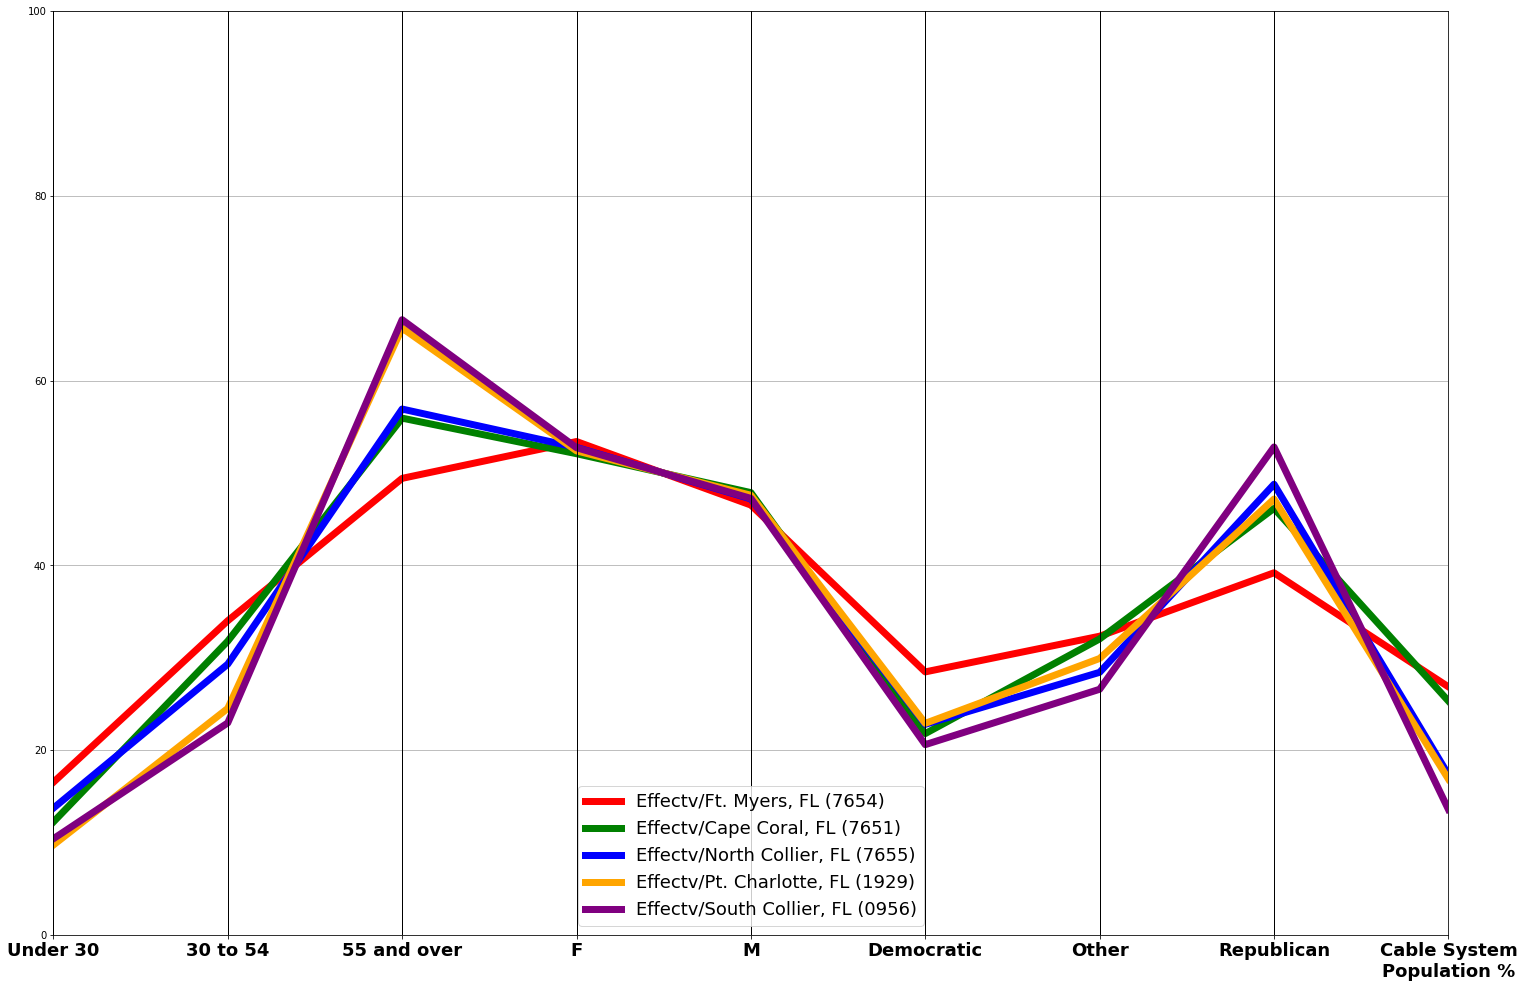

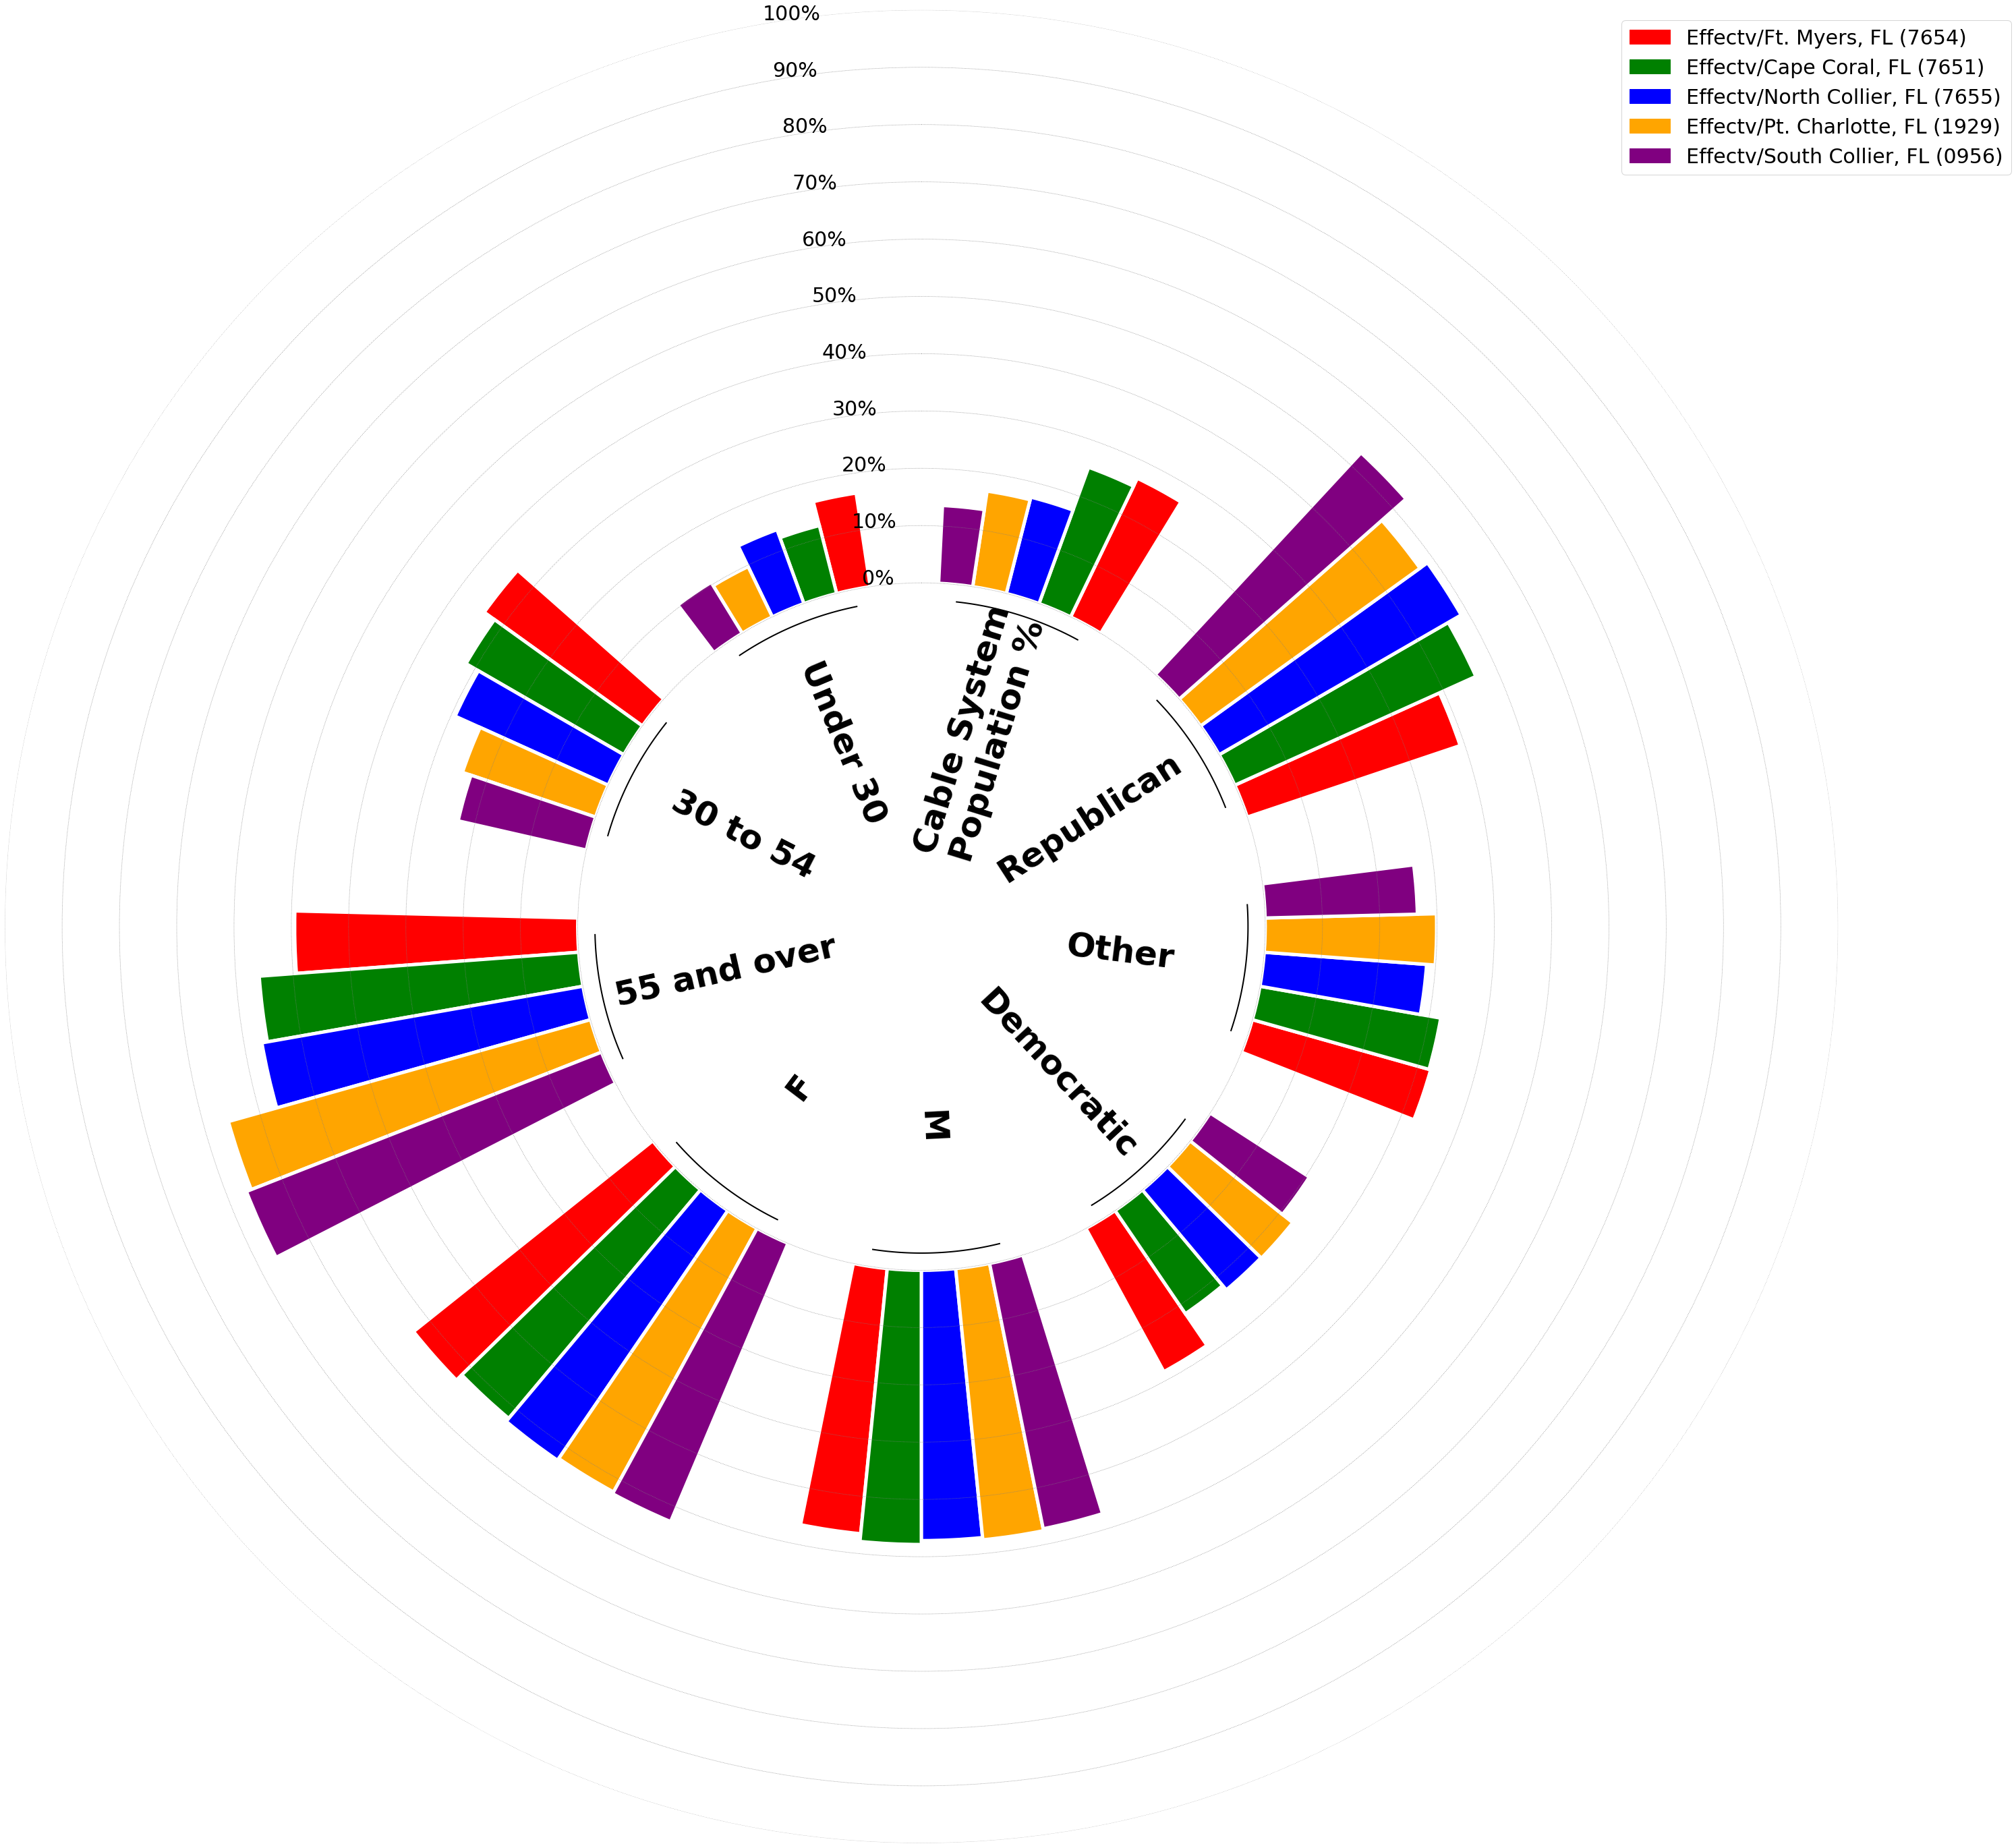

In [11]:
display(state_dma_hbox)